# Train supervised models

Problem: predict lap time D laps in the future in a new event based on the historical event data.

Baseline: extract time series for all the events, generate fixed length input and label pairs. These data can be then used in supervised models, including RF, SVR and NN.


In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

from indycar.notebook import *


### Load data and Initialization

In [2]:
# predict D lap in the future
D = 5 
# hidden utnits for LSTM
hunits = 16

In [41]:
#datalist = ['2017-all_completed_laps_diff.csv','2018-all_completed_laps_diff.csv' ]

#datalist = read_list('train_all.list')
datalist = read_list('train_completed.list')
scaler, dataset, dblens = load_data(datalist)

# get event idx
firstcar = np.cumsum(dblens)
event_idx = [0]
event_idx.extend(list(firstcar)[:-1])

dataset.info(verbose=True)
print('dataset shape', dataset.shape)

load data/Barber-2018-completed_laps_diff.csv, len=797
load data/Gateway-2018-completed_laps_diff.csv, len=1992
load data/Indy500-2017-completed_laps_diff.csv, len=3216
load data/IndyGP-2018-completed_laps_diff.csv, len=1806
load data/Iowa-2018-completed_laps_diff.csv, len=1505
load data/LongBeach-2018-completed_laps_diff.csv, len=1204
load data/Mid-Ohio-2018-completed_laps_diff.csv, len=1274
load data/Phoenix-2018-completed_laps_diff.csv, len=2761
load data/Pocono-2018-completed_laps_diff.csv, len=804
load data/Portland-2018-completed_laps_diff.csv, len=1907
load data/RoadAmerica-2018-completed_laps_diff.csv, len=1008
load data/StPete-2018-completed_laps_diff.csv, len=1554
load data/Texas-2018-completed_laps_diff.csv, len=2241
load data/Toronto-2018-completed_laps_diff.csv, len=1290
load data/Indy500-2018-completed_laps_diff.csv, len=3618
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26977 entries, 0 to 3617
Data columns (total 8 columns):
Unnamed: 0        26977 non-null int64
ca

In [4]:
# generate train/test dataset

# post-padding with 0
X, y, w = generate_data(dataset, D=D, target='time')

total = np.sum(dblens)
ntrain = np.sum(dblens[:-1])
nval = int(dblens[-1] / 2)
print('train=%d, val=%d, test=%d'%(ntrain, nval, total-ntrain-nval))

X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]
#weights
w_train, w_val, w_test = w[:ntrain], w[ntrain:ntrain + nval], w[ntrain+nval:]
print('train shape:', X_train.shape)

carNumber = 200, max T =301
train=182, val=9, test=9
train shape: (182, 296, 1)


### convert time series into vectors

In [5]:
vec_len = 20
fv_x_train, fv_y_train, idx_train = generate_feature_vectors(X_train, y_train, w_train, vec_len)
fv_x_val, fv_y_val, idx_val = generate_feature_vectors(X_val, y_val, w_val, vec_len)
fv_x_test, fv_y_test, idx_test = generate_feature_vectors(X_test, y_test, w_test, vec_len)
#get event idx from idx array
first_in_event_idx = idx_train[event_idx[:-1]]

In [6]:
fv_x_train.shape, fv_x_test.shape, idx_train.shape

((18991, 20), (1593, 20), (182,))

In [ ]:
#ts = X_train[0,:,0]
#ts[ts>0]

In [ ]:
#ts = X_train[0,:,0]
#np.sum(ts>0)
#fv_x_train[-1], fv_y_train[-1]

In [ ]:
#ts_y = y_train[0,:,0]
#ts_y[ts>0]

In [ ]:
#firstcar = np.cumsum(dblens)
#idx = [0]
#idx.extend(list(firstcar)[:-1])
#plot_examples(X[idx],y[idx],ypreds=None,nm_ypreds=None)
#plot_examples(X[:10],y[:10],ypreds=None,nm_ypreds=None)

## Define model

In [28]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def lstm_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful=stateful,
                    name="RNN")(inp)

    #dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    dens = layers.Dense(in_out_neurons,name="dense")(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    #model = models.Model(inputs=[inp],outputs=[rnn])
    
    #model.compile(loss="mean_squared_error",
    #              sample_weight_mode="temporal",
    #              optimizer="rmsprop")
    
    model.compile(loss="mean_absolute_error",
                  #sample_weight_mode="temporal",
                  optimizer="adam")
    
    return(model,(inp,rnn))

def svr_model():
    return SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)

def rf_model():
    return RandomForestRegressor(max_depth=3, criterion='mae',random_state=0,
                             n_estimators=20, n_jobs=-1)



In [40]:
print(fv_y_test[:10])
# svm model
svm_model = svr_model()
print(svm_model)
model_svm = svm_model.fit(fv_x_train,fv_y_train)
svm_result = predict('svr',model_svm, fv_x_test, fv_y_test, scaler)
print(svm_result[0][:10])

[0.1170318  0.11888945 0.12039819 0.11779228 0.11621398 0.11709358
 0.11854499 0.11729048 0.11990416 0.11784673]
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr model mae=0.079421, raw mae=17.868908, raw mape=38.701261
[0.20068368 0.20886516 0.20839118 0.20844493 0.20854282 0.20844369
 0.208569   0.20888885 0.20892666 0.20873804]


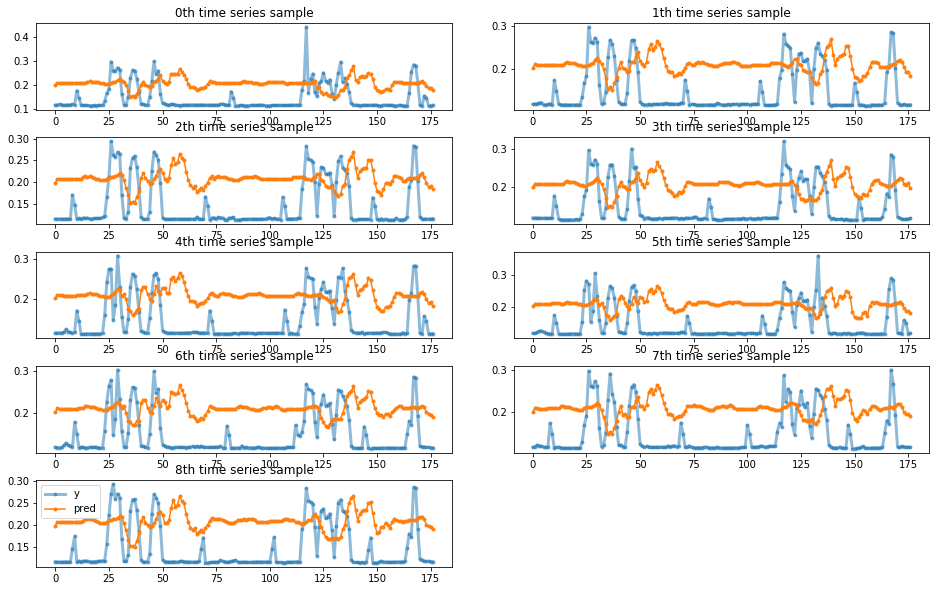

The final validation loss MAE is 0.079421


In [21]:
plot_vectors(fv_y_test,svm_result[0],idx_test)

In [39]:
# rf model
rf_ = rf_model()
print(rf_)
model_rf = rf_.fit(fv_x_train,fv_y_train)
rf_result = predict('rf', model_rf, fv_x_test, fv_y_test, scaler)
print(rf_result[0][:10])

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
rf model mae=0.033898, raw mae=7.626576, raw mape=11.170540
[0.11662568 0.11662568 0.11662568 0.11662568 0.11662568 0.11662568
 0.11662568 0.11662568 0.11662568 0.11662568]


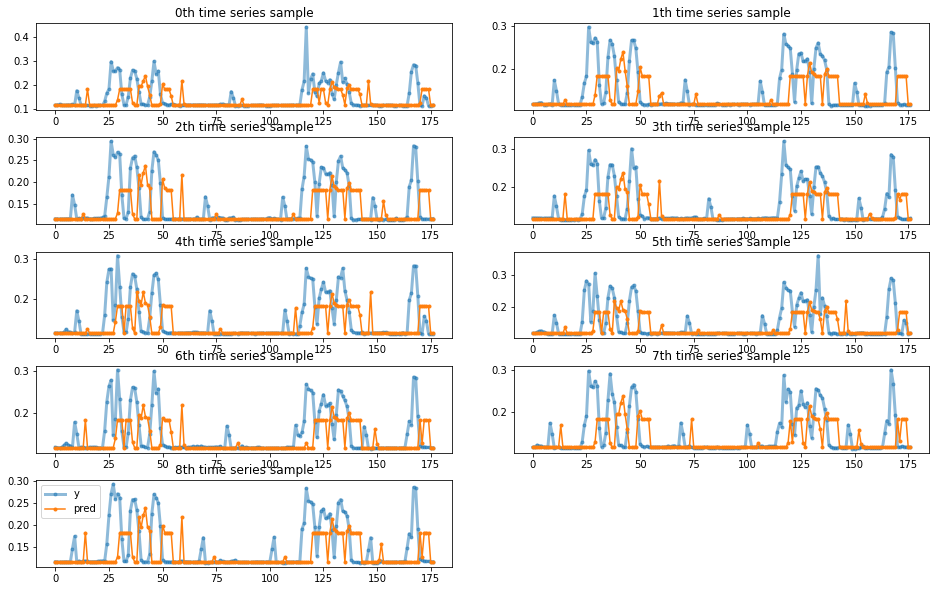

The final validation loss MAE is 0.033898


In [23]:
plot_vectors(fv_y_test,rf_result[0],idx_test)

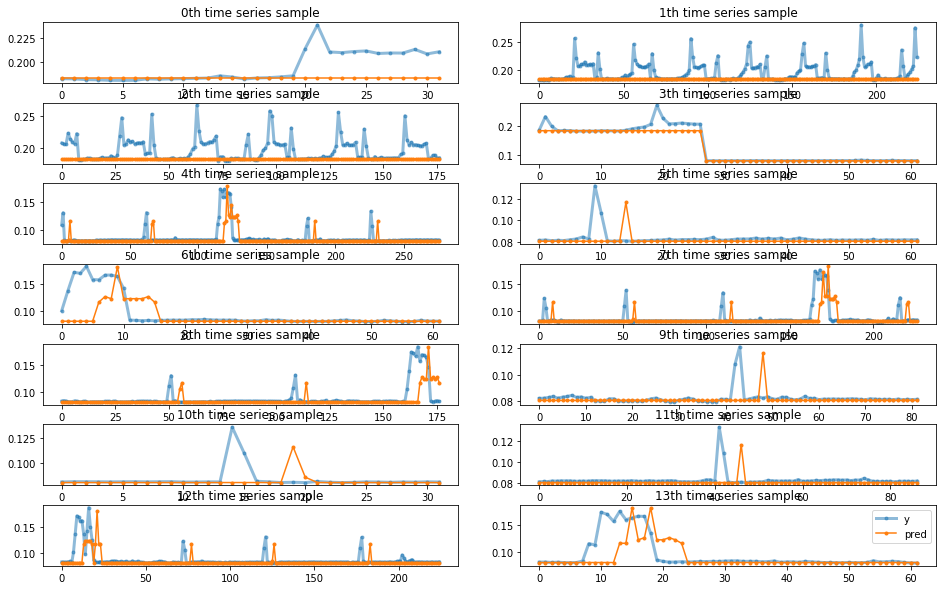

The final validation loss MAE is 0.017569


In [44]:
y_train_pred = model_rf.predict(fv_x_train)
plot_vectors(fv_y_train,y_train_pred,first_in_event_idx)

In [24]:
#lstm model
model_lstm, _ = lstm_model(
                    hidden_neurons = hunits,
                    len_ts = vec_len)
model_lstm.summary()
start = time.time()
n,m = fv_x_train.shape
val_n, val_m = fv_x_val.shape
w_train = np.ones((n,m))
w_val = np.ones((val_n,val_m))

history = model_lstm.fit(fv_x_train.reshape((n,m,1)),fv_y_train.reshape((n,1)),
                             batch_size=128,
                             shuffle=True,
                             epochs=500,
                             verbose=2,
                             validation_data=(fv_x_val.reshape((val_n,val_m,1)),
                                              fv_y_val.reshape((val_n,1))))
                             #sample_weight=w_train,                    
                             #validation_data=(fv_x_val.reshape((val_n,val_m,1)),
                             #                 fv_y_val.reshape((val_n,1)),w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20, 1)             0         
_________________________________________________________________
RNN (LSTM)                   (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________

Train on 18991 samples, validate on 1593 samples
Epoch 1/500
 - 4s - loss: 0.0463 - val_loss: 0.0361
Epoch 2/500
 - 3s - loss: 0.0222 - val_loss: 0.0361
Epoch 3/500
 - 3s - loss: 0.0220 - val_loss: 0.0357
Epoch 4/500
 - 3s - loss: 0.0220 - val_loss: 0.0359
Epoch 5/500
 - 3s - loss: 0.0219 - val_loss: 0.0357
Epoch 6/500
 - 3s - loss: 0.0219 - val_loss: 0.0356
Epoch 7/500
 - 3s - loss:

Epoch 136/500
 - 3s - loss: 0.0155 - val_loss: 0.0378
Epoch 137/500
 - 3s - loss: 0.0155 - val_loss: 0.0375
Epoch 138/500
 - 3s - loss: 0.0154 - val_loss: 0.0379
Epoch 139/500
 - 3s - loss: 0.0154 - val_loss: 0.0374
Epoch 140/500
 - 3s - loss: 0.0154 - val_loss: 0.0378
Epoch 141/500
 - 3s - loss: 0.0154 - val_loss: 0.0372
Epoch 142/500
 - 3s - loss: 0.0153 - val_loss: 0.0380
Epoch 143/500
 - 3s - loss: 0.0154 - val_loss: 0.0377
Epoch 144/500
 - 3s - loss: 0.0153 - val_loss: 0.0370
Epoch 145/500
 - 3s - loss: 0.0152 - val_loss: 0.0371
Epoch 146/500
 - 3s - loss: 0.0152 - val_loss: 0.0370
Epoch 147/500
 - 3s - loss: 0.0152 - val_loss: 0.0367
Epoch 148/500
 - 3s - loss: 0.0151 - val_loss: 0.0373
Epoch 149/500
 - 3s - loss: 0.0151 - val_loss: 0.0366
Epoch 150/500
 - 3s - loss: 0.0151 - val_loss: 0.0368
Epoch 151/500
 - 3s - loss: 0.0150 - val_loss: 0.0371
Epoch 152/500
 - 3s - loss: 0.0150 - val_loss: 0.0365
Epoch 153/500
 - 3s - loss: 0.0151 - val_loss: 0.0360
Epoch 154/500
 - 3s - loss: 

Epoch 288/500
 - 3s - loss: 0.0134 - val_loss: 0.0394
Epoch 289/500
 - 3s - loss: 0.0134 - val_loss: 0.0391
Epoch 290/500
 - 3s - loss: 0.0135 - val_loss: 0.0394
Epoch 291/500
 - 3s - loss: 0.0135 - val_loss: 0.0401
Epoch 292/500
 - 3s - loss: 0.0135 - val_loss: 0.0388
Epoch 293/500
 - 3s - loss: 0.0134 - val_loss: 0.0390
Epoch 294/500
 - 3s - loss: 0.0135 - val_loss: 0.0396
Epoch 295/500
 - 3s - loss: 0.0134 - val_loss: 0.0391
Epoch 296/500
 - 3s - loss: 0.0134 - val_loss: 0.0386
Epoch 297/500
 - 3s - loss: 0.0134 - val_loss: 0.0387
Epoch 298/500
 - 3s - loss: 0.0134 - val_loss: 0.0396
Epoch 299/500
 - 3s - loss: 0.0134 - val_loss: 0.0391
Epoch 300/500
 - 3s - loss: 0.0134 - val_loss: 0.0397
Epoch 301/500
 - 3s - loss: 0.0134 - val_loss: 0.0397
Epoch 302/500
 - 3s - loss: 0.0134 - val_loss: 0.0394
Epoch 303/500
 - 3s - loss: 0.0134 - val_loss: 0.0394
Epoch 304/500
 - 3s - loss: 0.0134 - val_loss: 0.0391
Epoch 305/500
 - 3s - loss: 0.0133 - val_loss: 0.0392
Epoch 306/500
 - 3s - loss: 

Epoch 440/500
 - 3s - loss: 0.0128 - val_loss: 0.0419
Epoch 441/500
 - 3s - loss: 0.0128 - val_loss: 0.0419
Epoch 442/500
 - 3s - loss: 0.0128 - val_loss: 0.0426
Epoch 443/500
 - 3s - loss: 0.0128 - val_loss: 0.0419
Epoch 444/500
 - 3s - loss: 0.0128 - val_loss: 0.0429
Epoch 445/500
 - 3s - loss: 0.0128 - val_loss: 0.0423
Epoch 446/500
 - 3s - loss: 0.0128 - val_loss: 0.0430
Epoch 447/500
 - 3s - loss: 0.0128 - val_loss: 0.0419
Epoch 448/500
 - 3s - loss: 0.0128 - val_loss: 0.0426
Epoch 449/500
 - 3s - loss: 0.0128 - val_loss: 0.0425
Epoch 450/500
 - 3s - loss: 0.0128 - val_loss: 0.0421
Epoch 451/500
 - 3s - loss: 0.0129 - val_loss: 0.0426
Epoch 452/500
 - 3s - loss: 0.0128 - val_loss: 0.0431
Epoch 453/500
 - 3s - loss: 0.0128 - val_loss: 0.0432
Epoch 454/500
 - 3s - loss: 0.0128 - val_loss: 0.0433
Epoch 455/500
 - 3s - loss: 0.0128 - val_loss: 0.0428
Epoch 456/500
 - 2s - loss: 0.0128 - val_loss: 0.0428
Epoch 457/500
 - 3s - loss: 0.0128 - val_loss: 0.0424
Epoch 458/500
 - 3s - loss: 

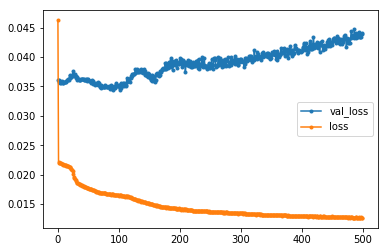

In [37]:
for line in history.history.keys():
    plt.plot(history.history[line],marker='.',label=line)
plt.legend()

lstm model mae=0.042930, raw mae=9.658819, raw mape=15.498554
[[0.11632396]
 [0.11679666]
 [0.11721157]
 [0.1176651 ]
 [0.11686191]
 [0.11706722]
 [0.11808011]
 [0.11893314]
 [0.1175255 ]
 [0.11664529]]


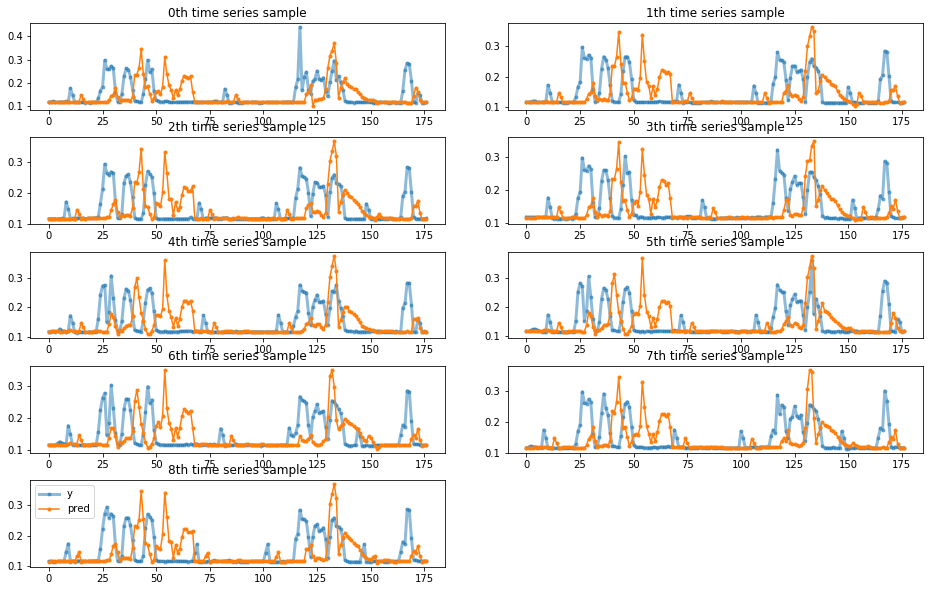

The final validation loss MAE is 0.042930


In [38]:
#n,m = fv_x_test.shape
#y_pred = model.predict(fv_x_test.reshape((n,m,1)))
#y_pred.shape
lstm_result = predict('lstm', model_lstm, fv_x_test, fv_y_test, scaler)
print(lstm_result[0][:10])
plot_vectors(fv_y_test,lstm_result[0],idx_test)

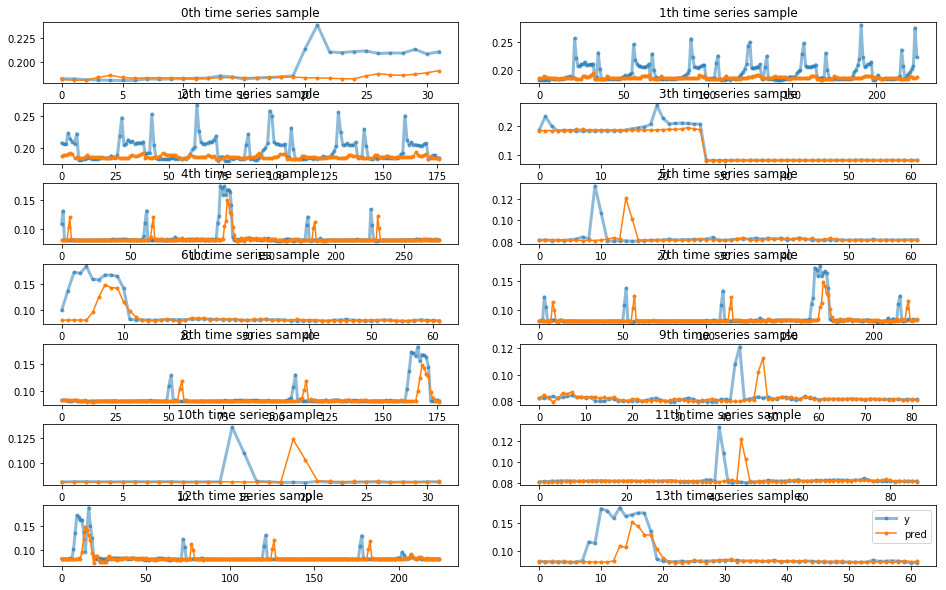

The final validation loss MAE is 0.012535


In [43]:
# training set
n,m = fv_x_train.shape
y_train_pred = model_lstm.predict(fv_x_train.reshape((n,m,1)))
plot_vectors(fv_y_train,y_train_pred,first_in_event_idx)

### Result Analysis




In [33]:
mape = [x[3] for x in [svm_result, rf_result, lstm_result]]
namelist = ['svm','rf','lstm']
df=pd.DataFrame({'name':namelist, 'D=5':mape})
df

,name,D=5
0,svm,38.701261
1,rf,11.170540
2,lstm,15.498554


### conclusion
RF works better than lstm and svr (in current parameters). 

MAPE is as high as 11%-15%.